### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix, classification_report
from sklearn.pipeline import *

from custom_transformers import *

import matplotlib.pyplot as plt

### Loading Data Sets

In [2]:
data_folder = '../VIDHYA_LOAN_PREDICTION_PROBLEM/'
data_file1 = 'train_dataset_1.csv'
data_file2 = 'test_dataset_1.csv'

train = pd.read_csv(data_folder + data_file1)
xpred = pd.read_csv(data_folder + data_file2)

In [3]:
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Bin_Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,5849.0,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,2900.0,1
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,4106.0,1
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8312.0,1
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,7583.0,1


In [4]:
xpred

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Bin_Loan_Status
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,5720,0
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,4576,0
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,6800,0
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,4886,0
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,3276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,5786,0
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,4867,0
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban,5243,0
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,7393,0


### Applying train_test_split before do some transformers in pipelines and then avoid data leakage

In [5]:
df_train, df_test = train_test_split(train, test_size = 0.3, random_state=42)

In [6]:
X_train = df_train.drop('Bin_Loan_Status', axis=1)
X_test = df_test.drop('Bin_Loan_Status', axis=1)

y_train = df_train['Bin_Loan_Status']
y_test = df_test['Bin_Loan_Status']

### Creating some lists of columns by type of preprocessing with pipelines

In [7]:
OUTCOME = 'Loan_Status'

CAT_FEATS = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']

NUM_FEATS1 = ['ApplicantIncome', 'CoapplicantIncome', 'Total_Income', 'LoanAmount']

NUM_FEATS2 = ['Loan_Amount_Term']

### Preprocessing features

In [8]:
pipeline_features = Pipeline([
    
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('mode', DFImputerMostFrequent()),
            ('dummy', DummyTransformer())
            
        ])),
        
        ('numericals_1', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS1)),
            ('missing_median', DFImputerMedian()),
            ('log', Log1pTransformer()),
            ('scale', DFRobustScaler())
             
        ])),
        
        ('numericals_2', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS2)),
            ('most_freq', DFImputerMostFrequent()),
            ('log', Log1pTransformer()),
            ('scale', DFRobustScaler())
            
        ]))
        
    ]))        
    
])

X_train_t = pipeline_features.fit_transform(X_train)
X_test_t = pipeline_features.transform(X_test)
X_pred = pipeline_features.transform(xpred)

Preprocessing was done after train_test_split to avoid data leakage.

### Creating a baseline with Logistic Regression with default settings

In [9]:
model_baseline = LogisticRegression()
model_baseline.fit(X_train_t, y_train)
p_pred_baseline_test = model_baseline.predict_proba(X_test_t)[:, 1]
auc_baseline_test = roc_auc_score(y_test, p_pred_baseline_test)

print('ROC Curve area: ' + round(auc_baseline_test, 3).astype(str))

ROC Curve area: 0.548


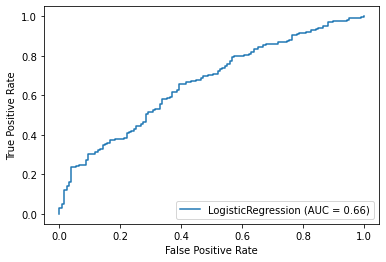

In [21]:
plot_roc_curve(model_baseline, X_train_t, y_train)  
plt.show()

ROC Curve Area from Baseline is nearest to 0,5 so it's not the best classifier. If it was nearest at one it would be better to a classifier. 

Lets try some improvements like do some tuning from hyperparameters. Maybe helps explain the model better.

Confusion Matrix:

In [10]:
pd.DataFrame(
    confusion_matrix(y_test, model_baseline.predict(X_test_t)),
    columns=['Predict Negative', 'Predicted Positive'],
    index=['Real Negative', 'Real Positive']
)

# [True  Negative (TN), False Positive (FP)]
# [False Negative (FN), True  Positive (TP)]

,Predict Negative,Predicted Positive
Real Negative,2,63
Real Positive,2,118


### Feature Selection

Tuning Hyperparameters from Lasso Regression:

In [11]:
pipeline_hyper = Pipeline([('pipeline_features',pipeline_features),
                           ('lasso', Lasso())
                          ])

# Creating a dictionary of all the parameter options 
parameters = dict(lasso__alpha = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 
                                  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                  1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  lasso__max_iter = [2800, 3000, 4000, 5000, 6000, 7000],
                  lasso__random_state = [42]
                 )

# Conducting Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipeline_hyper, parameters)

# Fitting the grid search
clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pipeline_features',
                                        Pipeline(steps=[('features',
                                                         <custom_transformers.DFFeatureUnion object at 0x000001DD0303B208>)])),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.05, 0.06, 0.07, 0.08, 0.09,
                                          0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                          10],
                         'lasso__max_iter': [2800, 3000, 4000, 5000, 6000,
                                             7000],
                         'lasso__random_state': [42]})

Printing the Best Parameters and evaluation model:

In [12]:
alpha = clf.best_estimator_.get_params()['lasso__alpha']
max_iter = clf.best_estimator_.get_params()['lasso__max_iter']

# Viewing The Best Parameters
print('Best Number Of Alpha:', alpha)
print('Best Number Of Max Iter:', max_iter)

print(); print(clf.best_estimator_.get_params()['lasso'])



# Using Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1, scoring='r2')
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Number Of Alpha: 0.01
Best Number Of Max Iter: 2800

Lasso(alpha=0.01, max_iter=2800, random_state=42)

[-0.02665895  0.05366801 -0.08181217 -0.01617686  0.08100557  0.00086018
  0.06309358  0.06751903 -0.01208693 -0.18104169]

-0.005163022485972802

0.07635689828207427


In [13]:
# Apply Feature Selection:
# 1) Specify the Lasso Regression model with hyperparameters tunned with GridSearchCV (alpha and max_iter)
# 2) How bigger alpha is less features that will be selected.
# 3) SelectFromModel from sklearn was used to select the features which coefficients are different of zero

feature_sel_model = SelectFromModel(Lasso(alpha = alpha,
                                          max_iter = max_iter,
                                          random_state=42)) # remember to set the seed, the random state in this function

feature_sel_model.fit(X_train_t, y_train)

SelectFromModel(estimator=Lasso(alpha=0.01, max_iter=2800, random_state=42))

In [14]:
# Boolean flag to indicate which features will be used on model
feature_sel_model.fit(X_train_t, y_train).get_support()

array([False,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False])

In [15]:
# Make a list of the selected features
selected_feat = X_train_t.columns[(feature_sel_model.get_support())]

# Printing some stats
print('total features: {}'.format((X_train_t.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('selected features: {}'.format(list(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(feature_sel_model.estimator_.coef_ == 0)))

total features: 20
selected features: 4
selected features: ['Dependents=1', 'Married=No', 'Property_Area=Semiurban', 'CoapplicantIncome']
features with coefficients shrank to zero: 16


In [16]:
model = LogisticRegression()

pipeline_model = Pipeline([('extract', ColumnExtractor(selected_feat)), 
                           ('model', model)])

params_pipe_log_reg = {'model__C': [0.01, 0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 1000],
                       'model__solver': ['liblinear', 'saga'],
                       'model__penalty': ['l1'], 
                       'model__random_state': [42],
                       #'model__n_jobs': [-1],
                       'model__max_iter': [100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000],
                       'model__class_weight': ['balanced']                     
                      }


cv_method = KFold(n_splits=10,
                  shuffle = True,
                  random_state=42)


clf = GridSearchCV(pipeline_model, params_pipe_log_reg, cv=cv_method, scoring='f1')

clf.fit(X_train_t, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('extract',
                                        <custom_transformers.ColumnExtractor object at 0x000001DD03798D48>),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.01, 0.001, 0.0001, 0.1, 0.2, 0.3, 0.4,
                                      0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100,
                                      1000],
                         'model__class_weight': ['balanced'],
                         'model__max_iter': [100, 200, 300, 500, 1000, 1500,
                                             2000, 2500, 3000],
                         'model__penalty': ['l1'], 'model__random_state': [42],
                         'model__solver': ['liblinear', 'saga']},
             scoring='f1')

In [17]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('extract', <custom_transformers.ColumnExtractor at 0x1dd039e3248>),
  ('model',
   LogisticRegression(C=0.7, class_weight='balanced', penalty='l1',
                      random_state=42, solver='liblinear'))],
 'verbose': False,
 'extract': <custom_transformers.ColumnExtractor at 0x1dd039e3248>,
 'model': LogisticRegression(C=0.7, class_weight='balanced', penalty='l1',
                    random_state=42, solver='liblinear'),
 'model__C': 0.7,
 'model__class_weight': 'balanced',
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 100,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': 42,
 'model__solver': 'liblinear',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [18]:
model = LogisticRegression(C=0.7,
                           solver='liblinear',
                           #class_weight={0: 0.69, 1: 0.31},
                           class_weight='balanced', 
                           #n_jobs=8, 
                           penalty='l1', 
                           random_state=42)

pipeline_model = Pipeline([('extract', ColumnExtractor(selected_feat)), 
                           ('model', model)])

pipeline_model.fit(X_train_t, y_train)
p_pred_test = pipeline_model.predict_proba(X_test_t)[:, -1]
auc_roc_predproba = roc_auc_score(y_test, p_pred_test)
print('ROC Curve area: ' + round(auc_roc_predproba, 3).astype(str))

ROC Curve area: 0.528


Confusion Matrix:

In [19]:
pred = pipeline_model.predict(X_test_t)

pd.DataFrame(
    confusion_matrix(y_test, pred),
    columns=['Predict Negative', 'Predicted Positive'],
    index=['Real Negative', 'Real Positive']
)

# [True  Negative (TN), False Positive (FP)]
# [False Negative (FN), True  Positive (TP)]

,Predict Negative,Predicted Positive
Real Negative,30,35
Real Positive,52,68


Plot ROC Curve:

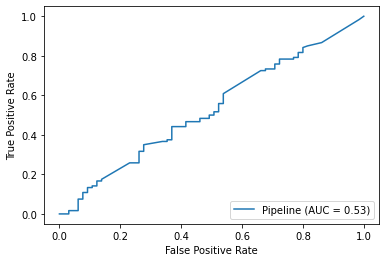

In [20]:
plot_roc_curve(pipeline_model, X_test_t, y_test)  
plt.show()

ROC Curve Area from the model is nearest to 0,5 and it's lower than ROC Curve Area from the baseline.

Remember that baseline there isn't any penalty like into the model and it probably penalysed the model.

This model isn't the best classifier. If it was nearest at one it would be better to a classifier. 

Like a improvement it would be better look for another features maybe helps explain the model better.

In [22]:
pred_serie = pipeline_model.predict(X_pred)
id = xpred['Loan_ID']

pd.DataFrame([id, pred_serie]).T.rename(columns=({'Unnamed 0':'Approved = 1 or Not Approved = 0'}))

,Loan_ID,Approved = 1 or Not Approved = 0
0,LP001015,0
1,LP001022,0
2,LP001031,1
3,LP001035,1
4,LP001051,0
...,...,...
362,LP002971,1
363,LP002975,0
364,LP002980,1
365,LP002986,1
